In [3]:
!cat utils.py
from utils import *

"""
DUNE CVN test module.
"""
__version__ = '1.0'
__author__ = 'Saul Alonso-Monsalve, Leigh Howard Whitehead'
__email__ = "saul.alonso.monsalve@cern.ch, leigh.howard.whitehead@cern.ch"

import shutil
import numpy as np
import pickle as pk
import sys
import os
import argparse

sys.path.append('./modules')

from tensorflow.keras.models import model_from_json
from sklearn.metrics import classification_report, confusion_matrix
from data_generator import DataGenerator
from opts import get_args
from keras.models import load_model
from keras.utils import plot_model
import my_losses
from dune_cvn import CustomTrainStep

# manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"



2024-11-29 16:32:19.631605: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 16:32:19.631693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 16:32:19.631704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 16:32:19.638731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
test_values = []
TEST_PARAMS = {'batch_size':1, #batch size for network evaluation (model.predict)
               'images_path':'../../vmeddage/images/CC_ELECTRON_EVENTS/training/', # folder where all the images lie
               'shuffle':False, # whether we want to shuffle the files (doesn't matter for us, since we're just evaluating them one by one)
               'test_values':test_values}

In [5]:
# load dataset into IDs, labels 
def get_labels():
  #print('Reading dataset from serialized file...')
  filename = TEST_PARAMS['images_path']+'/event_r1_s1000_e10_sl0_h1667247925.info'
  with open(filename, 'rb') as partition_file:
      labels = pk.load(partition_file)
      IDs = list(labels.keys())
  #print('Loaded. Number of test examples for flavor %s : %d'%(flav,len(IDs)))
  return IDs, labels

In [6]:
get_labels()

UnpicklingError: invalid load key, '5'.

In [23]:
import zlib
# this function reads the .gz image file given an argument like '0' or '1' or '2' and so on
def get_pixelmap(file): # with a default value
    #path = TEST_PARAMS['images_path']+'/'
    with open(file, 'rb') as image_file:
        pixels = np.frombuffer(bytearray(zlib.decompress(image_file.read())), dtype=np.uint8).reshape(3, 500, 500)
        return pixels

In [8]:
get_pixelmap()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [9]:
def get_eventinfo():
    path = TEST_PARAMS['images_path']+'/'
    ret = {}
    with open(path+'event_r1_s1000_e10_sl0_h1667247925.info', 'rb') as info_file:
        info = info_file.readlines()
        ret['NuPDG'] = int(info[7].strip())
        ret['NuEnergy'] = float(info[1])
        ret['LepEnergy'] = float(info[2])
        ret['Interaction'] = int(info[0].strip()) % 4
        ret['NProton'] = int(info[8].strip())
        ret['NPion'] = int(info[9].strip())
        ret['NPiZero'] = int(info[10].strip())
        ret['NNeutron'] = int(info[11].strip())
        #ret['OscWeight'] = float(info[6])
    return ret

In [10]:
get_eventinfo()

{'NuPDG': 12,
 'NuEnergy': 2.93775,
 'LepEnergy': 0.654855,
 'Interaction': 1,
 'NProton': 1,
 'NPion': 1,
 'NPiZero': 0,
 'NNeutron': 0}

In [11]:
import matplotlib.pylab as plt

# useful variable which we use in the code later on
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
# function meant to draw an image. Input here is the image that we obtain from the previous function get_pixelmap
def draw_single_pm(pm):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='twilight')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

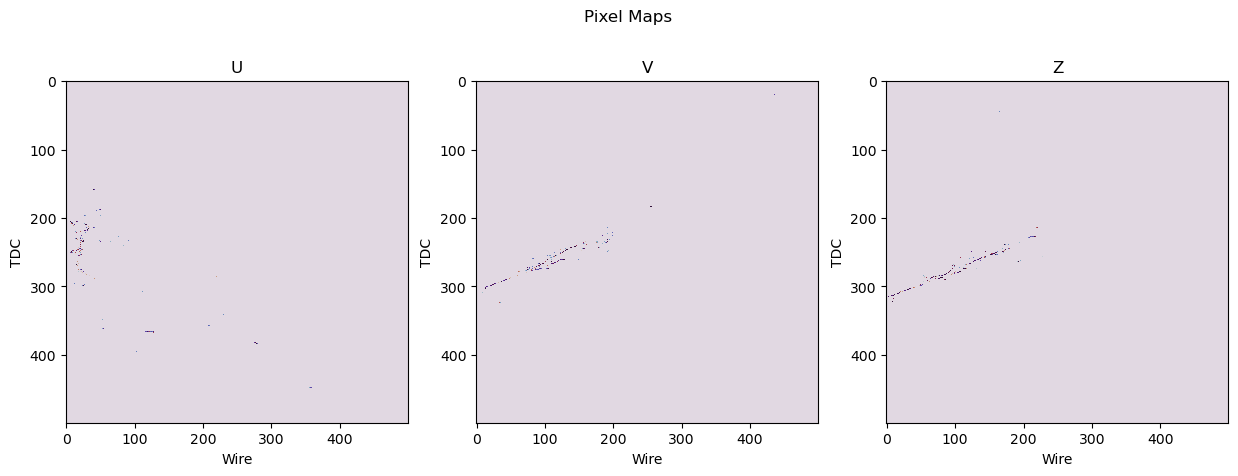

In [24]:
pm = get_pixelmap('zlib/event_r1_s359_e1_sl1_h1732910769.gz')
draw_single_pm(pm)

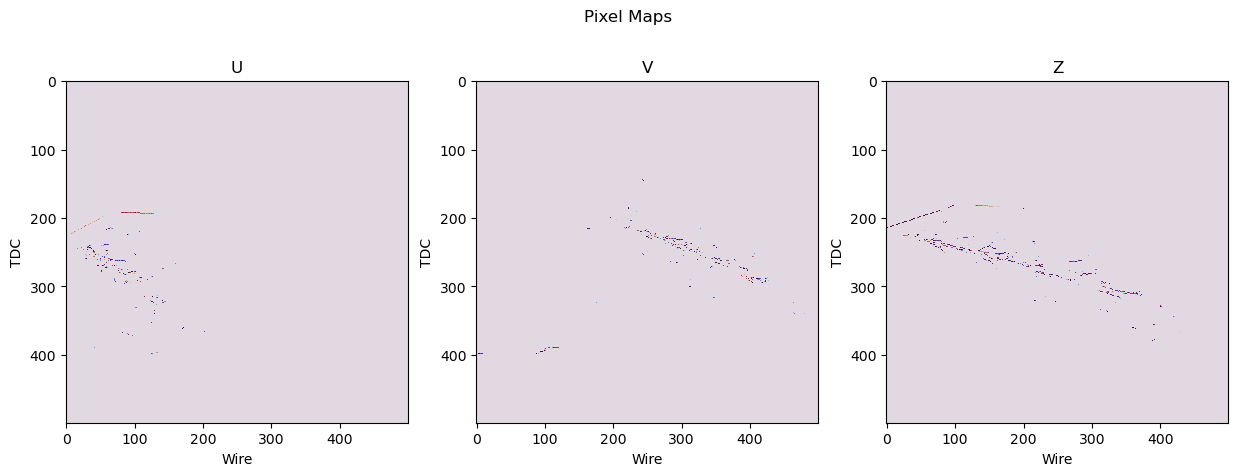

In [25]:
pm = get_pixelmap('zlib/event_r1_s359_e2_sl2_h1732911412.gz')
draw_single_pm(pm)

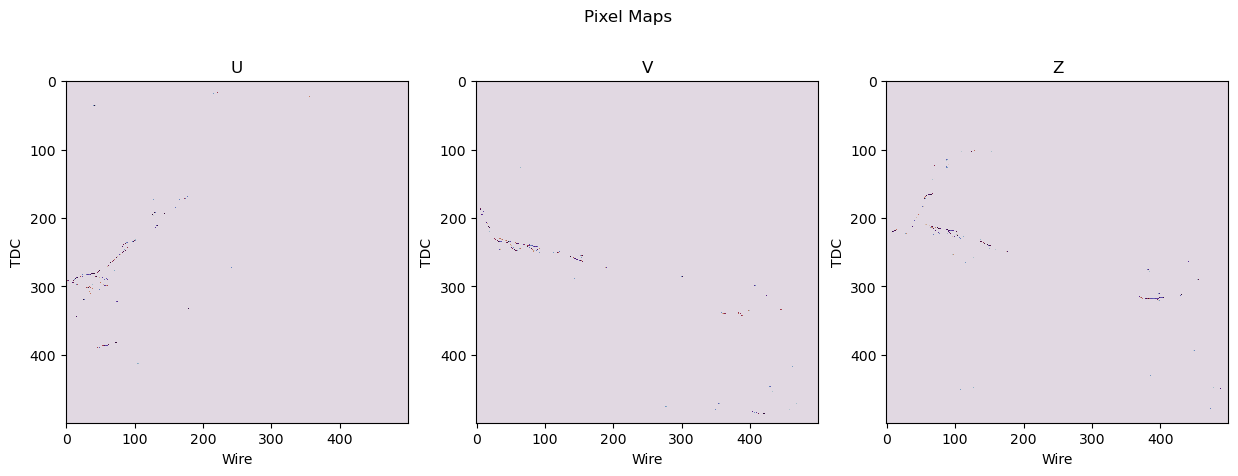

In [36]:
pm = get_pixelmap('zlib/event_r1_s359_e9_sl1_h1732918646.gz')
draw_single_pm(pm)

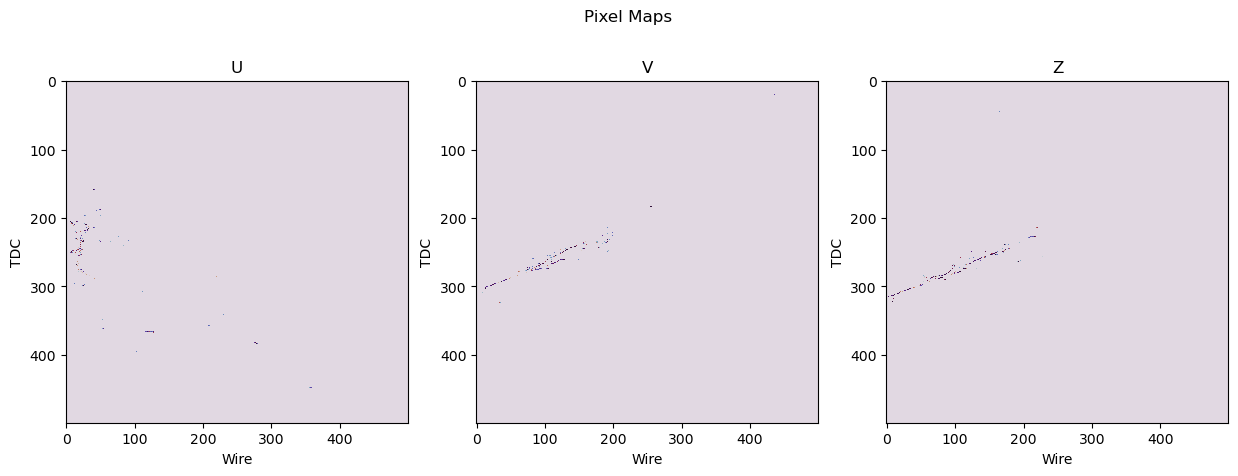

In [38]:
pm = get_pixelmap('zlib/event_r1_s359_e1_sl1_h1733002093.gz')
draw_single_pm(pm)